<a href="https://colab.research.google.com/github/eoinbridgeman2001-crypto/Data-Acquisition-Project/blob/main/Sample_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Question 1 - Cleaning

In [16]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [17]:
#Load dataset
df = pd.read_csv("travel_exam_dataset.csv")
df.head()

#Inspect the data
#print(df.head())
#print(df.info())
#print(df.isnull().sum())

,booking_id,passenger_age,travel_class,origin_city,destination_city,booking_date,departure_date,ticket_price,partner,payment_status,review_text
0,1,56.0,Economy,Rome,Berlin,2023-09-28,2023-11-22,54.92,FlyNow,Failed,Great flight!
1,2,28.0,Business,Dublin,Paris,10/04/2023,2023-04-28,624.23,AirX,Paid,Terrible delay.
2,3,70.0,Business,Dublin,Paris,2023-10-21,17/10/2023,113.71,FlyNow,Pending,NaN
3,4,39.0,Economy,London,Rome,18/02/2023,12/04/2023,113.48,GoSky,Paid,Terrible delay.
4,5,45.0,Premium,Dublin,Dublin,28/09/2023,2023-11-23,197.01,GoSky,Pending,NaN


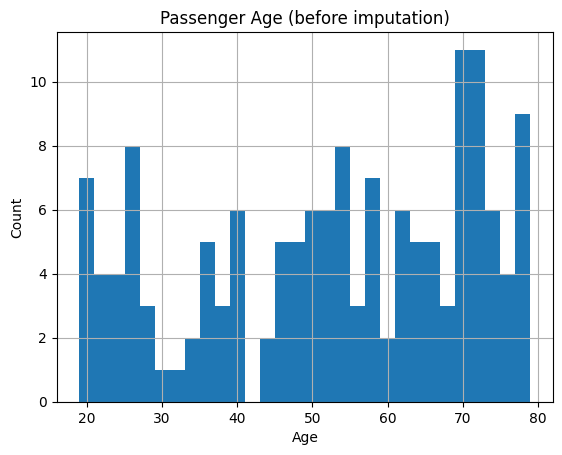

In [18]:
#Look at distribution before imputing
df['passenger_age'].hist(bins=30)
plt.title("Passenger Age (before imputation)")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [19]:
#Impute missing ages with the median (robust to outliers)

age_median = df['passenger_age'].median()
df['passenger_age'] = df['passenger_age'].fillna(age_median)

In [20]:
#Partner(categorical)

#Normalise obvious placeholders to NaN first
df['partner'] = df['partner'].replace(['', 'N/A', 'na', 'NaN'], np.nan)

print("Partner value counts (before filling):")
print(df['partner'].value_counts(dropna=False))

Partner value counts (before filling):
partner
AirX      40
NaN       40
GoSky     39
FlyNow    31
Name: count, dtype: int64


In [21]:
#Fill missing with explicit category "Unknown"
df['partner'] = df['partner'].fillna("Unknown")

print("Partner value counts (after filling):")
print(df['partner'].value_counts(dropna=False))

Partner value counts (after filling):
partner
AirX       40
Unknown    40
GoSky      39
FlyNow     31
Name: count, dtype: int64


In [22]:
#Check that Q1.1 is complete
print("Missing values after Q1.1:")
print(df[['passenger_age', 'partner']].isnull().sum())

Missing values after Q1.1:
passenger_age    0
partner          0
dtype: int64


In [23]:
#Convert to datetime even with mixed formats

df['booking_date'] = pd.to_datetime(
    df['booking_date'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)

df['departure_date'] = pd.to_datetime(
    df['departure_date'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)

print("Dtypes:")
print(df[['booking_date','departure_date']].dtypes)

print("\nMissing after parsing (NaT values):")
print(df[['booking_date','departure_date']].isnull().sum())


Dtypes:
booking_date      datetime64[ns]
departure_date    datetime64[ns]
dtype: object

Missing after parsing (NaT values):
booking_date      0
departure_date    0
dtype: int64


Question 2 - Transforming

In [24]:
#travel_class: nominal - One Hot Encoding
ohe = OneHotEncoder(sparse_output=False, drop='first')  # drop first = avoids dummy variable trap
encoded = ohe.fit_transform(df[['travel_class']])

#Turn encoded array into DataFrame
encoded_cols = ohe.get_feature_names_out(['travel_class'])
encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)

In [25]:
# Merge encoded columns into df
df = pd.concat([df, encoded_df], axis=1)

In [26]:
#partner: binary - simple 0/1 encoding
df['partner_flag'] = df['partner'].map({
    'Yes': 1,
    'No': 0,
    'Unknown': 0   #Treat Unknown as 0 or separate
})

In [27]:
#Check encoding
print(df[['travel_class'] + list(encoded_cols) + ['partner', 'partner_flag']].head())

  travel_class  travel_class_Economy  travel_class_Premium partner  \
0      Economy                   1.0                   0.0  FlyNow   
1     Business                   0.0                   0.0    AirX   
2     Business                   0.0                   0.0  FlyNow   
3      Economy                   1.0                   0.0   GoSky   
4      Premium                   0.0                   1.0   GoSky   

   partner_flag  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  


travel_class is nominal with no meaningful order, so OneHotEncoder is appropriate.
Using drop='first' prevents the dummy variable trap and keeps features independent.

partner is a binary variable (Yes/No). One-hot encoding is unnecessary, so a simple
0/1 encoding is more compact and interpretable.

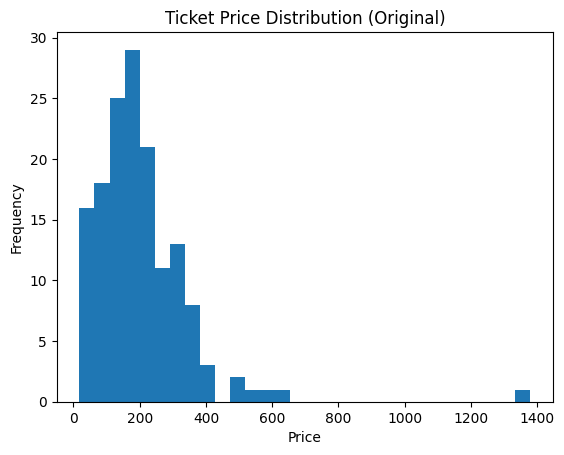

In [28]:
#Plot histogram before scaling
plt.hist(df['ticket_price'], bins=30)
plt.title("Ticket Price Distribution (Original)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

In [29]:
#Check skew
skew_value = df['ticket_price'].skew()
print("Skew:", skew_value)

Skew: 3.6790582338106286


In [30]:
#Scale using StandardScaler
scaler = StandardScaler()
df['ticket_price_scaled'] = scaler.fit_transform(df[['ticket_price']])

In [31]:
#Quick check
df[['ticket_price', 'ticket_price_scaled']].head()

,ticket_price,ticket_price_scaled
0,54.92,-0.979327
1,624.23,2.826707
2,113.71,-0.586295
3,113.48,-0.587833
4,197.01,-0.029406


ticket_price is right-skewed, but scaling is still required so numeric features are
comparable for ML algorithms. StandardScaler is more robust than MinMaxScaler in the
presence of skew because it centres data at mean 0 with variance 1.

MinMaxScaler can compress most data into a tiny range if outliers exist, so
StandardScaler is the better choice here.

In [32]:
#Discretise ticket price

df['price_level'] = pd.qcut(
    df['ticket_price'],
    q=3,
    labels=['low', 'medium', 'high']
)

print(df[['ticket_price', 'price_level']].head())

   ticket_price price_level
0         54.92         low
1        624.23        high
2        113.71         low
3        113.48         low
4        197.01      medium


I used quantile binning (qcut) to create three groups: low, medium, and high.
Quantile bins ensure each category contains an equal number of samples, producing
balanced classes. This avoids issues where equal-width bins produce empty or very
small groups due to skewed distributions.

Question 3

In [33]:
#Duration feature

df['days_between_booking_and_departure'] = (
    df['departure_date'] - df['booking_date']
).dt.days

df[['booking_date', 'departure_date', 'days_between_booking_and_departure']].head()

,booking_date,departure_date,days_between_booking_and_departure
0,2023-09-28,2023-11-22,55
1,2023-04-10,2023-04-28,18
2,2023-10-21,2023-10-17,-4
3,2023-02-18,2023-04-12,53
4,2023-09-28,2023-11-23,56


In [34]:
#Extract departure month

df['departure_month'] = df['departure_date'].dt.month

df[['departure_date', 'departure_month']].head()


,departure_date,departure_month
0,2023-11-22,11
1,2023-04-28,4
2,2023-10-17,10
3,2023-04-12,4
4,2023-11-23,11


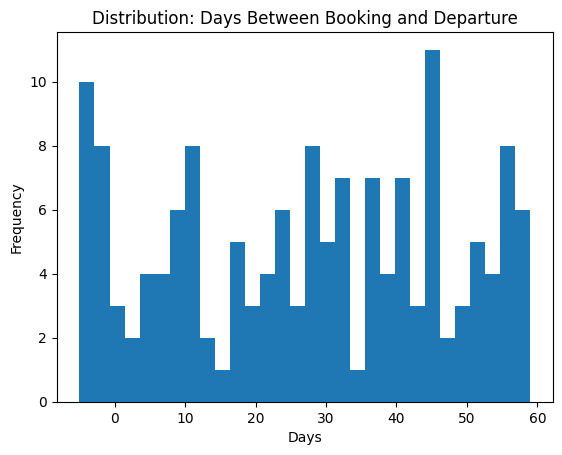

In [36]:
#Histogram - Days between booking and departure
plt.hist(df['days_between_booking_and_departure'], bins=30)
plt.title("Distribution: Days Between Booking and Departure")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()

The distribution is strongly right-skewed. Most passengers book their trip close to the departure date, while a smaller number book many days in advance. This long tail suggests a mix of last-minute and well-planned travelers.

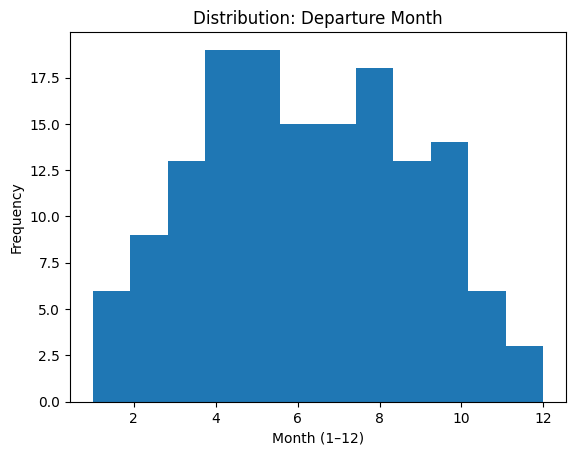

In [37]:
#Histogram - Departure Month
plt.hist(df['departure_month'], bins=12)
plt.title("Distribution: Departure Month")
plt.xlabel("Month (1–12)")
plt.ylabel("Frequency")
plt.show()

The departure_month feature shows seasonal variation, with some months having noticeably more departures. This suggests that travel activity is influenced by holidays or seasonal demand. The feature is categorical-numeric (1–12) and may require encoding depending on the ML approach.